## Import Modules

In [1]:
import cv2
from matplotlib import pyplot
import numpy as np
from numpy import matlib

# Definitions

In [62]:
def shift(register, feedback, output):
    """GPS Shift Register
    
    :param list feedback: which positions to use as feedback (1 indexed)
    :param list output: which positions are output (1 indexed)
    :returns output of shift register:
    
    """
    
    # calculate output
    out = [register[i-1] for i in output]
    if len(out) > 1:
        out = sum(out) % 2
    else:
        out = out[0]
        
    # modulo 2 add feedback
    fb = sum([register[i-1] for i in feedback]) % 2
    
    # shift to the right
    for i in reversed(range(len(register[1:]))):
        register[i+1] = register[i]
        
    # put feedback in position 1
    register[0] = fb
    
    return out

In [63]:
def PRN(sv):
    """Build the CA code (PRN) for a given satellite ID
    
    :param int sv: satellite code (1-32)
    :returns list: ca code for chosen satellite
    
    """
    
    # init registers
    G1 = [1 for i in range(10)]
    G2 = [1 for i in range(10)]

    ca = [] # stuff output in here
    
    # create sequence
    for i in range(1023):
        g1 = shift(G1, [3,10], [10])
        g2 = shift(G2, [2,3,6,8,9,10], SV[sv]) # <- sat chosen here from table
        
        # modulo 2 add and append to the code
        ca.append((g1 + g2) % 2)

    # return C/A code!
    return ca

# Constants

In [4]:
SV = {
   1: [2,6],
   2: [3,7],
   3: [4,8],
   4: [5,9],
   5: [1,9],
   6: [2,10],
   7: [1,8],
   8: [2,9],
   9: [3,10],
  10: [2,3],
  11: [3,4],
  12: [5,6],
  13: [6,7],
  14: [7,8],
  15: [8,9],
  16: [9,10],
  17: [1,4],
  18: [2,5],
  19: [3,6],
  20: [4,7],
  21: [5,8],
  22: [6,9],
  23: [1,3],
  24: [4,6],
  25: [5,7],
  26: [6,8],
  27: [7,9],
  28: [8,10],
  29: [1,6],
  30: [2,7],
  31: [3,8],
  32: [4,9],
}

## Read Image and display it

In [5]:
im1 = cv2.imread('Images/Images/Image1.png')

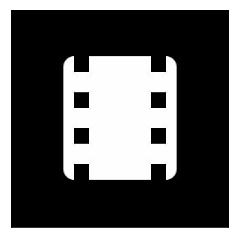

In [6]:
pyplot.imshow(im1)
pyplot.xticks([]), pyplot.yticks([])
pyplot.show()

## Convert Image to array

In [7]:
im1array = np.array(im1)
im1array.shape

(225, 225, 3)

In [8]:
im1flat =im1array.flatten()
print(im1flat.shape)
print(type(im1flat[0]))


(151875,)
<class 'numpy.uint8'>


In [9]:
bitfeed = im1flat
print(len(bitfeed))

151875


In [10]:
im1reshape = np.reshape(im1flat, (225,225,3))

## Plot the reshaped flattened array

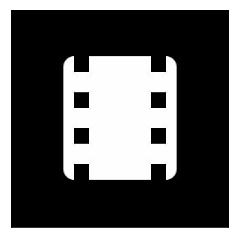

In [11]:
pyplot.imshow(im1reshape)
pyplot.xticks([]), pyplot.yticks([])
pyplot.show()

# Generate P Codes

In [12]:
# init registers
G1 = [1 for i in range(10)]
G2 = [1 for i in range(10)]

# work out first 10 bits
ca = []
for i in range(10):
    g1 = shift(G1, [3,10], [10]) #feedback 3,10, output 10
    g2 = shift(G2, [2,3,6,8,9,10], [2,6]) #feedback 2,3,6,8,9,10, output 2,6 for sat 1
    ca.append((g1 + g2) % 2)

print(ca)

[1, 1, 0, 0, 1, 0, 0, 0, 0, 0]


In [13]:
sig1 = PRN(24)
sig2 = PRN(1)

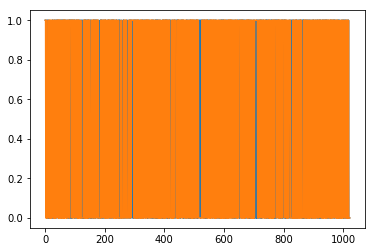

In [14]:
pyplot.plot(range(0, len(sig1)),sig1 )
pyplot.plot(range(0, len(sig2)),sig2 )

<class 'numpy.ndarray'> 1023 1023


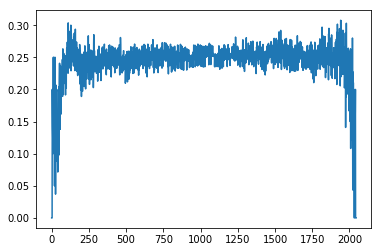

In [15]:
xcorr = np.correlate(sig1, sig2, "full")
print(type(xcorr), len(sig1), len(sig2))
bias = np.arange(1, len(sig1)) 

#print(np.flip(bias, 0))
fbias = np.concatenate((bias, len(sig1) + 1, np.flip(bias,0)), axis=None)

xcorr = xcorr/fbias
pyplot.plot(range(0, 2*len(sig1)-1),  xcorr)

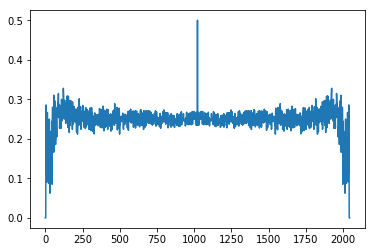

In [16]:
xcorr2 = np.correlate(sig1, sig1, "full")/fbias
pyplot.plot(range(0, 2*len(sig1)-1),  xcorr2)

In [17]:
bitcode = np.array(sig1)

# Combine Code with Image

In [18]:
rpts = int(np.ceil(len(bitfeed)/len(bitcode)))
print(rpts)

149


In [19]:
full_bitcode = matlib.repmat(bitcode, 1, rpts)

In [20]:
#pyplot.plot(bitcode)

In [21]:
full_bitcode.size

152427

In [22]:
paddedImage = np.pad(im1flat, (0, full_bitcode.size - bitfeed.size), 'constant', constant_values=(0,0))
paddedImage.size
full_bitcode.size

152427

In [23]:
codedImage = paddedImage ^ full_bitcode
print(codedImage.size)

152427


In [24]:
padding = full_bitcode.size - bitfeed.size

In [26]:
recovery = codedImage ^ full_bitcode

In [43]:
recovered_lesspadding = recovery[:, 0:recovery.size-padding]
print(recovered_lesspadding)
print(recovery.size, recovered_lesspadding.size, recovery.size-padding )
print(max(max(recovery)), min(min(recovery)))

[[0 0 0 ..., 0 0 0]]
152427 151875 151875
255 0


In [60]:
recoveredim1 = np.reshape(recovered_lesspadding/255, (225,225,3))

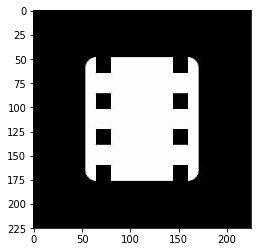

In [61]:
pyplot.imshow(recoveredim1)